In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [50]:
# Load the data
file_path = '/Users/jordannelson/Documents/OneDrive - UWE Bristol Merla Pumffrey/Masters Project/Data/Solar PV Weather.xlsx'
data = pd.read_excel(file_path)

# Display the first few rows of the dataset
print(data.head())

   Year Quarter  Average Temperature  Average daily sun hours  \
0  2010      Q1             3.470952                 2.707527   
1  2010      Q2            11.639325                 7.216409   
2  2010      Q3            15.457169                 4.873691   
3  2010      Q4             5.166641                 2.414651   
4  2011      Q1             5.631481                 2.615393   

   Installled Capacity (MW)  Generation (GWh)  Load Factor (%)  
0                      35.0              5.74             8.57  
1                      48.0             11.16            12.31  
2                      67.0             14.52            11.44  
3                      95.0              8.86             4.95  
4                     137.0             15.34             6.12  


In [52]:
# Summary of the dataset
print(data.info())

# Check for missing values
print(data.isnull().sum())

# Summary statistics
print(data.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57 entries, 0 to 56
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Year                      57 non-null     int64  
 1   Quarter                   57 non-null     object 
 2   Average Temperature       57 non-null     float64
 3   Average daily sun hours   57 non-null     float64
 4   Installled Capacity (MW)  57 non-null     float64
 5   Generation (GWh)          57 non-null     float64
 6   Load Factor (%)           57 non-null     float64
dtypes: float64(5), int64(1), object(1)
memory usage: 3.2+ KB
None
Year                        0
Quarter                     0
Average Temperature         0
Average daily sun hours     0
Installled Capacity (MW)    0
Generation (GWh)            0
Load Factor (%)             0
dtype: int64
              Year  Average Temperature  Average daily sun hours  \
count    57.000000            57.000000      

/var/folders/2w/hpz23rfj7l32vsh540rqdd_80000gn/T/ipykernel_66551/3918124512.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data.corr()


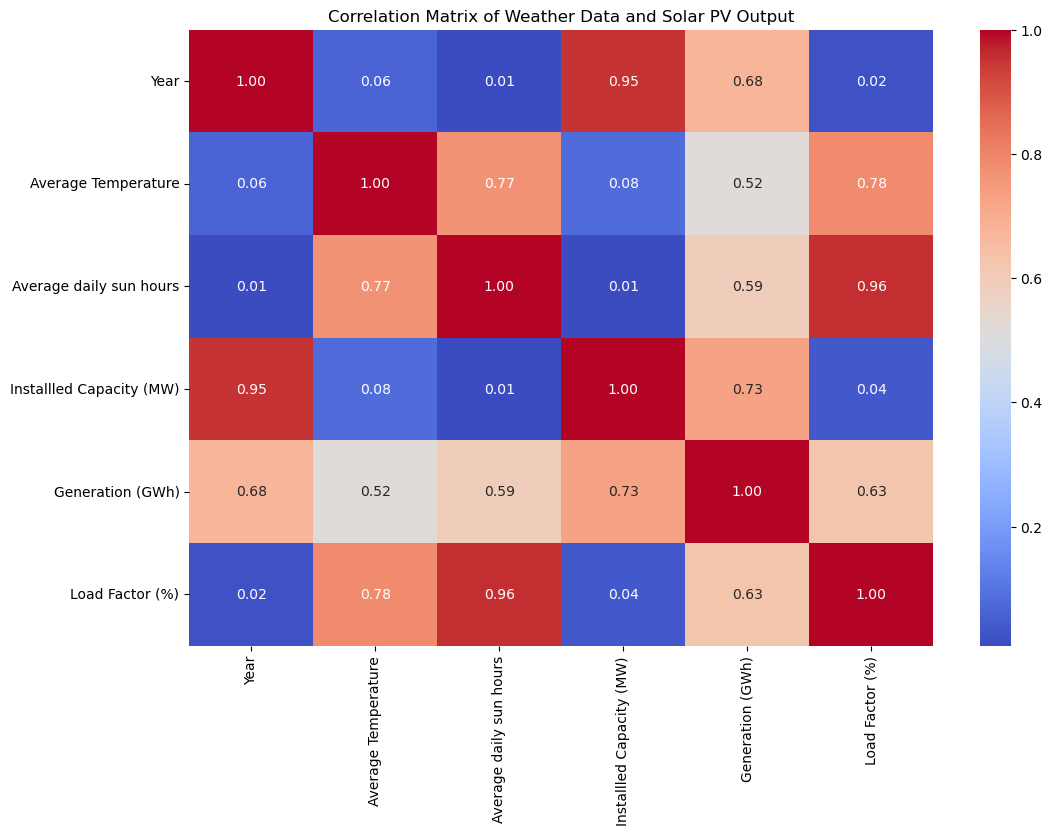

In [54]:
# Compute the correlation matrix
correlation_matrix = data.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Weather Data and Solar PV Output')
plt.show()

In [56]:
# Define the independent variables (weather data) and dependent variable (Solar PV output)
X = data[['Average Temperature','Average daily sun hours']]
y = data['Load Factor (%)']

# Add a constant to the independent variables matrix
X = sm.add_constant(X)

In [58]:
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the response
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

# Perform stepwise regression
result = stepwise_selection(X, y)

print('Selected features:')
print(result)


Add  Average daily sun hours        with p-value 3.46914e-32
Selected features:
['Average daily sun hours']


/var/folders/2w/hpz23rfj7l32vsh540rqdd_80000gn/T/ipykernel_66551/1868585416.py:22: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
/var/folders/2w/hpz23rfj7l32vsh540rqdd_80000gn/T/ipykernel_66551/1868585416.py:22: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


In [60]:
# Fit the OLS model with the selected features
X_selected = X[result]
model = sm.OLS(y, X_selected).fit()

# Print the full regression model summary
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:        Load Factor (%)   R-squared (uncentered):                   0.984
Model:                            OLS   Adj. R-squared (uncentered):              0.983
Method:                 Least Squares   F-statistic:                              3352.
Date:                Sat, 31 Aug 2024   Prob (F-statistic):                    1.17e-51
Time:                        08:16:13   Log-Likelihood:                         -102.04
No. Observations:                  57   AIC:                                      206.1
Df Residuals:                      56   BIC:                                      208.1
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

In [62]:
# Map the quarters to the first month of each quarter
data['Month'] = data['Quarter'].map({1: 1, 2: 4, 3: 7, 4: 10})

# Combine Year and Month into a new Date column
data['Date'] = pd.to_datetime(data[['Year', 'Month']].assign(DAY=1))

# Drop the Month column as it's no longer needed
data = data.drop(columns=['Month'])

print(data.head())

   Year Quarter  Average Temperature  Average daily sun hours  \
0  2010      Q1             3.470952                 2.707527   
1  2010      Q2            11.639325                 7.216409   
2  2010      Q3            15.457169                 4.873691   
3  2010      Q4             5.166641                 2.414651   
4  2011      Q1             5.631481                 2.615393   

   Installled Capacity (MW)  Generation (GWh)  Load Factor (%) Date  
0                      35.0              5.74             8.57  NaT  
1                      48.0             11.16            12.31  NaT  
2                      67.0             14.52            11.44  NaT  
3                      95.0              8.86             4.95  NaT  
4                     137.0             15.34             6.12  NaT  


In [64]:
X = data[['Average daily sun hours']]

# Actual values
y_true = data['Load Factor (%)']

# Predicted values
y_pred = model.predict(X)

# Mean Squared Error (MSE)
mse = mean_squared_error(y_true, y_pred)
print(f"Mean Squared Error (MSE): {mse:.2f}")

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_true, y_pred)
print(f"Mean Absolute Error (MAE): {mae:.2f}")

# R-squared (R2)
r2 = r2_score(y_true, y_pred)
print(f"R-squared (R2): {r2:.2f}")

# Adjusted R-squared
n = len(y_true)  
p = X.shape[1] - 1  
adjusted_r2 = 1 - (1 - r2) * ((n - 1) / (n - p - 1))
print(f"Adjusted R-squared: {adjusted_r2:.2f}")

Mean Squared Error (MSE): 2.10
Root Mean Squared Error (RMSE): 1.45
Mean Absolute Error (MAE): 1.11
R-squared (R2): 0.91
Adjusted R-squared: 0.91


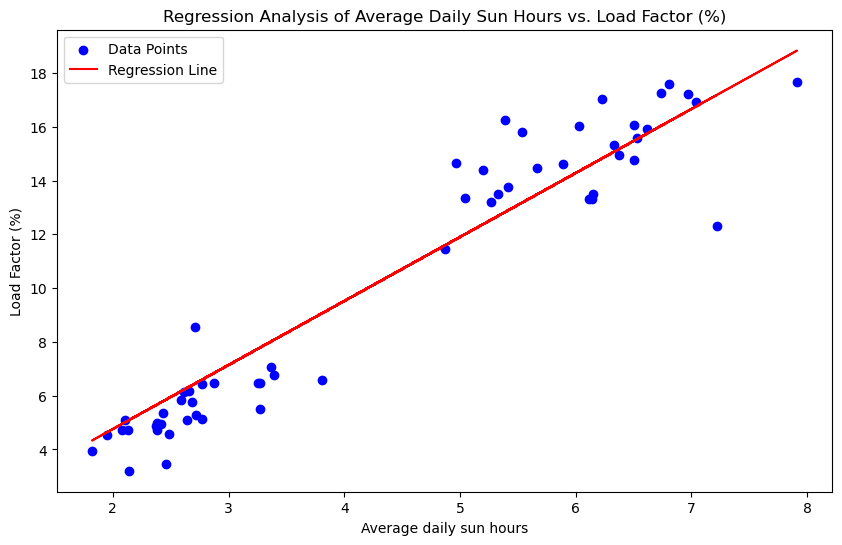

In [66]:
# Plotting the regression line
plt.figure(figsize=(10, 6))
plt.scatter(data['Average daily sun hours'], data['Load Factor (%)'], color='blue', label='Data Points')
plt.plot(data['Average daily sun hours'], model.predict(X), color='red', label='Regression Line')
plt.xlabel('Average daily sun hours')
plt.ylabel('Load Factor (%)')
plt.title('Regression Analysis of Average Daily Sun Hours vs. Load Factor (%)')
plt.legend()
plt.show()